<a href="https://colab.research.google.com/github/Suh-Nee/puterbot/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

### Loading Kaggle Dataset


In [ ]:
!pip install wget

In [ ]:
!wget 'https://github.com/raymanhuang/aps360data/raw/main/Dataset.zip' -O Kaggle_Dataset.zip

In [ ]:
!unzip 'Kaggle_Dataset.zip' -d '/root/datasets'

### Splitting Kaggle Dataset


In [ ]:
# mobile_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

mobile_transforms = models.MobileNet_V2_Weights.DEFAULT.transforms()

train_data = ImageFolder('/root/datasets/Dataset/train', transform=mobile_transforms)
val_data = ImageFolder('/root/datasets/Dataset/val', transform=mobile_transforms)
test_data = ImageFolder('/root/datasets/Dataset/test', transform=mobile_transforms)

### Loading MobileNetV2 Model

In [ ]:
# Load the pre-trained MobileNetV2 model
mobile_model = models.mobilenet_v2(pretrained=True)

# Freeze the weights of the convolutional base
for param in mobile_model.features.parameters():
    param.requires_grad = False

# Modify the classifier for 3 classes: No Mask, Mask, and Mask Improper
mobile_model.classifier[1] = nn.Linear(mobile_model.last_channel, 3)

### Training Model

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval()

    for imgs, labels in data_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def get_val_performance(model, data_loader):
    correct = 0
    total = 0
    avg_loss = 0.0
    it = 0
    criterion = nn.CrossEntropyLoss()
    model.eval()

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            output = model(imgs)
            loss = criterion(output, labels)
            avg_loss += loss.item()
            it += 1

            #select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

    accuracy = correct / total
    loss = float(avg_loss) / it

    return accuracy, loss

In [ ]:
def train_net(model, batch_size, learning_rate, num_epochs):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, val_loss , val_acc = [], [], []

    # training
    start_time=time.time()
    for epoch in range(num_epochs):
        avg_loss = 0.0
        it = 0
        model.train()

        for imgs, labels in train_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            avg_loss += loss.item()
            it += 1

        train_loss.append(float(avg_loss) / it)
        va, vl = get_val_performance(model, val_loader)
        val_loss.append(vl)
        val_acc.append(va)

        print("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print(f"Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    end_time= time.time()

    # plotting
    plt.title("Epoch vs Loss")
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Epoch vs Accuracy")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 0 Finished.  Time per Epoch:  34.37 s 
Train Loss: 0.3376, Val Loss: 0.1834, Val Acc: 0.9419
Epoch 1 Finished.  Time per Epoch:  35.06 s 
Train Loss: 0.1994, Val Loss: 0.1431, Val Acc: 0.9484
Epoch 2 Finished.  Time per Epoch:  34.72 s 
Train Loss: 0.1686, Val Loss: 0.1044, Val Acc: 0.9702
Epoch 3 Finished.  Time per Epoch:  34.40 s 
Train Loss: 0.1601, Val Loss: 0.1481, Val Acc: 0.9579
Epoch 4 Finished.  Time per Epoch:  34.20 s 
Train Loss: 0.1479, Val Loss: 0.0876, Val Acc: 0.9775
Epoch 5 Finished.  Time per Epoch:  34.07 s 
Train Loss: 0.1425, Val Loss: 0.0860, Val Acc: 0.9775
Epoch 6 Finished.  Time per Epoch:  33.96 s 
Train Loss: 0.1335, Val Loss: 0.0897, Val Acc: 0.9739
Epoch 7 Finished.  Time per Epoch:  33.91 s 
Train Loss: 0.1262, Val Loss: 0.0791, Val Acc: 0.9753
Epoch 8 Finished.  Time per Epoch:  33.91 s 
Train Loss: 0.1254, Val Loss: 0.0802, Val Acc: 0.9760
Epoch 9 Finished.  Time per Epoch:  33.95 s 
Train Loss: 0.1205, Val Loss: 0.0810, Val Acc: 0.9746
Epoch 10 F

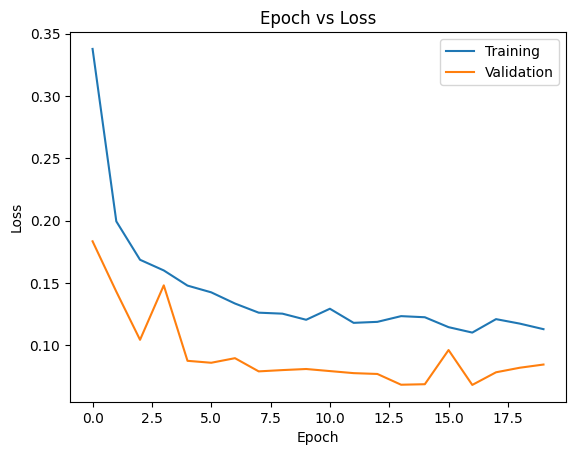

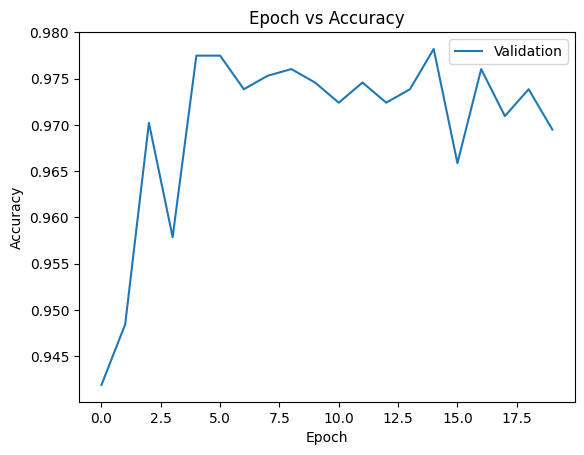

Final Validation Accuracy: 0.9694989106753813
Total time:   675.78 s  Time per Epoch:  33.79 s 


In [ ]:
mobile_model.cuda()
train_net(mobile_model, 32, 0.001, 20)